**Author: Heitor José Tessaro**


The purpose of this file is to train a CNN to perform event classification related to the operation of synchronous generator. A maximum of 15 classes are considered in the training process. 


---



Iimport libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader # gives easier dataset manegment and creates mini batches
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from google.colab import files
import zipfile
import glob
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix



Remove all existing files

In [ ]:
filesID = glob.glob('./*.eps')
for f in filesID:
    os.remove(f)

filesID = glob.glob('./*.npy')
for f in filesID:
    os.remove(f)    

filesID = glob.glob('./*.pth')
for f in filesID:
    os.remove(f)

filesID = glob.glob('./*.zip')
for f in filesID:
    os.remove(f)

filesID = glob.glob('./*.csv')
for f in filesID:
    os.remove(f)    

Upload csv file with data from files and respective classes

In [ ]:
files.upload()

Saving data.csv to data.csv


{'data.csv': b'File names,class \ndesenergizacao1.npy,0\ndesenergizacao2.npy,0\ndesenergizacao3.npy,0\ndesenergizacao4.npy,0\ndesenergizacao5.npy,0\ndesenergizacao6.npy,0\ndesenergizacao7.npy,0\ndesenergizacao8.npy,0\ndesenergizacao9.npy,0\ndesenergizacao10.npy,0\ndesenergizacao11.npy,0\ndesenergizacao12.npy,0\ndesenergizacao13.npy,0\ndesenergizacao14.npy,0\ndesenergizacao15.npy,0\ndesenergizacao16.npy,0\ndesenergizacao17.npy,0\ndesenergizacao18.npy,0\ndesenergizacao19.npy,0\ndesenergizacao20.npy,0\ndesenergizacao21.npy,0\ndesenergizacao22.npy,0\ndesenergizacao23.npy,0\ndesenergizacao24.npy,0\ndesenergizacao25.npy,0\ndesenergizacao26.npy,0\ndesenergizacao27.npy,0\ndesenergizacao28.npy,0\ndesenergizacao29.npy,0\ndesenergizacao30.npy,0\ndesenergizacao31.npy,0\ndesenergizacao32.npy,0\ndesenergizacao33.npy,0\ndesenergizacao34.npy,0\ndesenergizacao35.npy,0\ndesenergizacao36.npy,0\ndesenergizacao37.npy,0\ndesenergizacao38.npy,0\ndesenergizacao39.npy,0\ndesenergizacao40.npy,0\ndesenergizacao4

Shuffle the dataset

In [ ]:
df = pd.read_csv('data.csv')
df = df.sample(frac=1)
df = df.sample(frac=1)
df.to_csv('shuffled_data.csv',index = False)

Uploading the npyData file. This file contains the event data. The file must be compressed in zip format.

In [ ]:
filesID = glob.glob('./npyData/*')
for f in filesID:
    os.remove(f)

files.upload()

with zipfile.ZipFile("npyData.zip","r") as zip_ref:
    zip_ref.extractall(".")

Define the dataset class


In [ ]:
class EventosDataset(Dataset):
    # csv_file: provide the dataset file names and its class
    # root_dir: path to the files
    # transform: transformation to the data files
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotation = shuffle(pd.read_csv(csv_file))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotation) 

    def __getitem__(self,index):
        data_path = os.path.join(self.root_dir, self.annotation.iloc[index,0])
        np_data = np.load(data_path)
        data = torch.as_tensor(np_data)/255
        label = torch.tensor(int(self.annotation.iloc[index,1]))
        return(data,label)

    def __plotImage__(self):
        n_samples = dataset.__len__()
        index = random.randint(0, n_samples)
        data_path = os.path.join(self.root_dir, self.annotation.iloc[index,0])
        np_data = np.load(data_path)
        fig = plt.figure(figsize=(10, 7),constrained_layout=True)
        ax1 = plt.subplot(2,3,1)
        plt.imshow(np_data[0,:,:],cmap='gray',vmin=0,vmax=255)
        plt.axis('off')
        plt.title('Zero')
        plt.rc('font', size=18) 
        ax2 = plt.subplot(2,3,2)
        plt.imshow(np_data[1,:,:],cmap='gray',vmin=0,vmax=255)
        plt.axis('off')
        plt.title('Positive')
        ax3 = plt.subplot(2,3,3)
        plt.imshow(np_data[2,:,:],cmap='gray',vmin=0,vmax=255)
        plt.axis('off')
        plt.title('Negative')
        ax4 = plt.subplot(2,3,4)
        plt.imshow(np_data[3,:,:],cmap='gray')
        plt.axis('off')
        plt.title('Zero')
        ax5 = plt.subplot(2,3,5)
        plt.imshow(np_data[4,:,:],cmap='gray')
        plt.axis('off')
        plt.title('Positive')
        ax6 = plt.subplot(2,3,6)
        plt.imshow(np_data[5,:,:],cmap='gray')                                
        plt.axis('off')
        plt.title('Negative')
        plt.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.99, 
                    wspace=0.1, 
                    hspace=0.1)
        
        return print(self.annotation.iloc[index,0])

Defines the dataset. It is not necessary to use transformers to convert to a tensor because this has already been done directly in the dataset class.

In [ ]:
dataset = EventosDataset(csv_file = 'shuffled_data.csv', root_dir = './npyData',
                         transform= None)

Plots a random image of the dataset to test how it works.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


FaltaTriBT_G114.npy


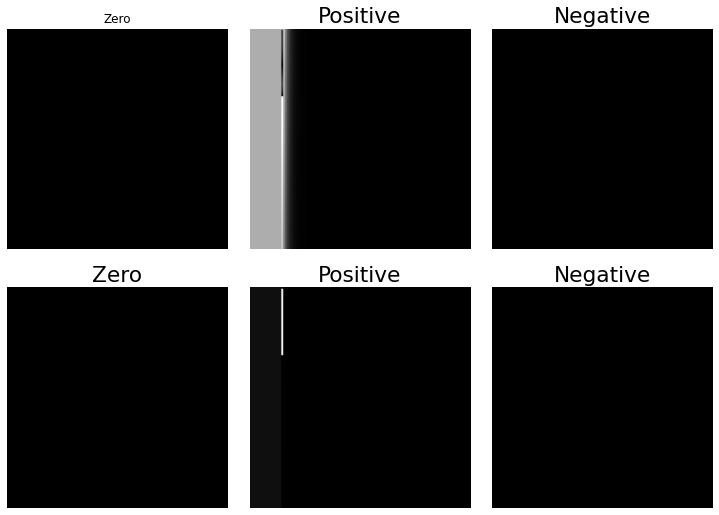

In [ ]:
dataset.__plotImage__()

Training and testing dataset definitions. The number of training epochs and the learning rate are also defined.

In [ ]:
# device config 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 40
batch_size = 90
learning_rate = 1e-3
visualize = 3600/batch_size/10

# training data (80%) and testing data (20%)
train_set, test_set = torch.utils.data.random_split(dataset, [3600, 900])

targets_loader = DataLoader(dataset, batch_size=4500)
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

Define the CNN

In [ ]:
# seed for random generation of weights of NN
torch.manual_seed(24) 

# NN definition
ConvNet = nn.Sequential(
    nn.Conv2d(in_channels= 6, out_channels= 36, 
                          kernel_size= 6, stride= 2 ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.BatchNorm2d(36),
    nn.Conv2d(in_channels= 36, out_channels= 50,
                               kernel_size= 6, stride= 1 ),    
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.BatchNorm2d(50),    
    nn.Conv2d(in_channels= 50, out_channels= 100,
                               kernel_size= 7, stride= 1 ), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.BatchNorm2d(100),    
    nn.Flatten(start_dim = 1),
    nn.Linear(in_features= 100*3*3, out_features= 300),
    nn.ReLU(),
    nn.Dropout(p= 0.3),
    nn.Linear(in_features= 300, out_features= 50),
    nn.ReLU(),
    nn.Dropout(p= 0.3),
    nn.Linear(in_features= 50, out_features= 15)
)


Adapt the network to the available device

In [ ]:
model = ConvNet.to(device)

Define the training and validation functions

In [ ]:
train_losses = []
train_accu = []

#for epoch in range(num_epochs):
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #forward
        outputs = model(images)
        # print(outputs)        
        loss = criterion(outputs, labels)

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # training info
        running_loss =+ loss.item()*images.size(0)
        # print(images.size(0))      
        _,predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % visualize == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f} ') 
    
    train_loss = running_loss / len(train_loader)
    accu = 100.*correct/total

    train_losses.append(train_loss)
    train_accu.append(accu)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

    return train_loss,accu

In [ ]:
eval_losses = []
eval_accu = []

def test(epoch):

    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for i, (images,labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            #forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # test info
            running_loss =+ loss.item()*images.size(0)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(train_loader)
    accu = 100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)
    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))

    return test_loss,accu

Perform the CNN trainning

In [ ]:
# multi class classification configuration
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,
                            weight_decay = 10e-5)

best_accu = 1.*0
best_loss = 10.1

# training
for epoch in range(num_epochs):
    tr_loss,tr_accu = train(epoch)
    te_loss,te_accu = test(epoch)
    av_loss = (tr_loss + te_loss)/2
    av_accu = (tr_accu + te_accu)/2
    if av_loss < best_loss:
        best_loss = av_loss
        # At this point save a snapshot of the current model
        torch.save(model.state_dict(),'model_best_loss.pth')
        best_loss_epoch = epoch+1
        print('A new best loss model')
    if av_accu > best_accu:
        best_accu = av_accu
        # At this point save a snapshot of the current model
        torch.save(model.state_dict(),'model_best_accu.pth') 
        best_accu_epoch = epoch+1  
        print('A new best accu model')     


Epoch [1/40], Step [4/40], Loss: 2.7215 
Epoch [1/40], Step [8/40], Loss: 2.6509 
Epoch [1/40], Step [12/40], Loss: 2.6134 
Epoch [1/40], Step [16/40], Loss: 2.5366 
Epoch [1/40], Step [20/40], Loss: 2.5091 
Epoch [1/40], Step [24/40], Loss: 2.4298 
Epoch [1/40], Step [28/40], Loss: 2.3204 
Epoch [1/40], Step [32/40], Loss: 2.2737 
Epoch [1/40], Step [36/40], Loss: 2.2122 
Epoch [1/40], Step [40/40], Loss: 2.2539 
Train Loss: 5.071 | Accuracy: 29.278
Test Loss: 5.313 | Accuracy: 31.333
A new best loss model
A new best accu model
Epoch [2/40], Step [4/40], Loss: 2.1948 
Epoch [2/40], Step [8/40], Loss: 2.0123 
Epoch [2/40], Step [12/40], Loss: 2.1236 
Epoch [2/40], Step [16/40], Loss: 2.1411 
Epoch [2/40], Step [20/40], Loss: 1.8152 
Epoch [2/40], Step [24/40], Loss: 2.1528 
Epoch [2/40], Step [28/40], Loss: 2.0241 
Epoch [2/40], Step [32/40], Loss: 2.0016 
Epoch [2/40], Step [36/40], Loss: 1.7587 
Epoch [2/40], Step [40/40], Loss: 1.7569 
Train Loss: 3.953 | Accuracy: 43.833
Test Loss:

Save the trainned models and download the zip files. Three models are saved: 1) The one resulting after the total epochs training; 2) The one which presented the best accuracy; 3) The one which presented the best loss;

In [ ]:
FILE = 'model.pth'
torch.save(model.state_dict(),FILE)
! zip pytorchModel.zip model.pth
files.download('./pytorchModel.zip')

updating: model.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(best_accu_epoch)
! zip pytorchModelBestAccu.zip model_best_accu.pth
files.download('./pytorchModelBestAccu.zip')

39
updating: model_best_accu.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(best_loss_epoch)
! zip pytorchModelBestLoss.zip model_best_loss.pth
files.download('./pytorchModelBestLoss.zip')

38
updating: model_best_loss.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot the training data together with the evaluation performed in parallel, save the figure, then download the figure file.

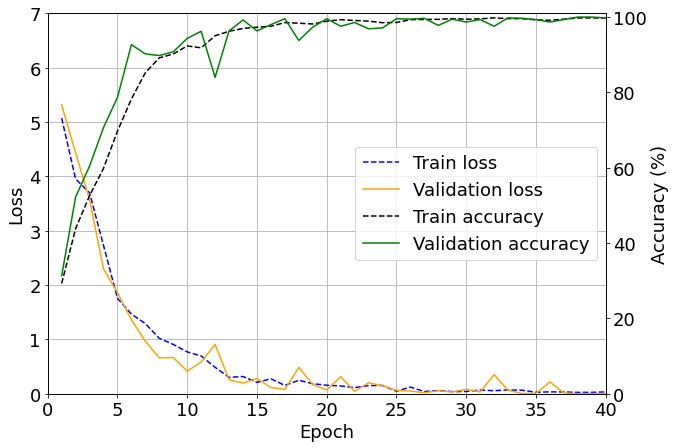

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot loss and acuracy
epoch_x = np.arange(1, 41, 1)

fig = plt.figure(figsize=(10,7))
plt.rc('font', size=18) #controls default text size
ax = fig.add_subplot(111)

lns1 = ax.plot(epoch_x,train_losses,'--', color='blue', label = 'Train loss')
lns2 = ax.plot(epoch_x,eval_losses,'-', color='orange', label = 'Validation loss')
ax2 = ax.twinx()
lns3 = ax2.plot(epoch_x,train_accu,'--', color='black', label = 'Train accuracy',)
lns4 = ax2.plot(epoch_x,eval_accu,'-', color='green', label = 'Validation accuracy')

# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel(r"Loss")
ax2.set_ylabel(r"Accuracy (%)")
ax2.set_ylim(0, 101)
ax.set_ylim(0,7)
ax.set_xlim(0,40)
plt.show()
fig.savefig(fname = 'loss_accuracy.eps' ,  bbox_inches='tight')
files.download('./loss_accuracy.eps')

Saves the training and evaluation data, then download as a zip file.

In [ ]:
np.save('./train_losses.npy', train_losses)
np.save('./eval_losses.npy', eval_losses)
np.save('./train_accu.npy', train_accu)
np.save('./eval_accu.npy', eval_accu)
! zip trainData.zip ./*.npy
files.download('./trainData.zip')

updating: eval_accu.npy (deflated 55%)
updating: eval_losses.npy (deflated 33%)
updating: train_accu.npy (deflated 49%)
updating: train_losses.npy (deflated 33%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload the CNN trainned parameters, set the motel to the evaluation mode.

In [ ]:
FILE = './model_best_accu.pth'
# load the parameters from the FILE
model.load_state_dict(torch.load(FILE))
# uses the network in the evaluation mode, witout calculating the gradients
model.to(device)
model.eval()

Sequential(
  (0): Conv2d(6, 36, kernel_size=(6, 6), stride=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(36, 50, kernel_size=(6, 6), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(50, 100, kernel_size=(7, 7), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=900, out_features=300, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=300, out_features=50, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.3, inplace=Fals

Presents the global accuracy and the accuracy for each class evaluated. Two classses set are presented. The first one considers each temporary fault event as a diferent class. The seccond one considers that all temporary fault events belong to just one class (NOOP05). 

In [ ]:
# define the name for each class. 

classes = ('DESE01', 'LINC02', 'LDEC03', 
           'SPFH04', 'SPFL05', 'DPFH06', 'DPFL07', 
           'DGFH08', 'DGFL09', 'SGFH10', 'SGFL11',
           'SPTH12', 'DPTH13', 'DGTH14', 
           'SGTH15' )

classes = ('DESE01', 'LINC02', 'LDEC03', 
           'SPFH04', 'SPFL05', 'DPFH06', 'DPFL07', 
           'DGFH08', 'DGFL09', 'SGFH10', 'SGFL11',
           'NOOP05')


with torch.no_grad():
    model.eval()
    acc = 0
    predicted = []
    n_correct = 0
    n_samples = 0
    n_class_correct = []
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = []
    n_class_samples = [0 for i in range(len(classes))]
    # print(n_class_correct)
    for images, labels in targets_loader:
        images = images.to(device)
        labels = labels.to(device)
        # print(labels.shape)
        outputs = model(images)

        # max returns (value, index)
        predicted = [0 for i in range(outputs.shape[0])]
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(outputs.shape[0]):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    print()

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 99.97777777777777 %

Accuracy of DESE01: 100.0 %
Accuracy of LINC02: 100.0 %
Accuracy of LDEC03: 100.0 %
Accuracy of SPFH04: 100.0 %
Accuracy of SPFL05: 100.0 %
Accuracy of DPFH06: 100.0 %
Accuracy of DPFL07: 100.0 %
Accuracy of DGFH08: 100.0 %
Accuracy of DGFL09: 100.0 %
Accuracy of SGFH10: 99.66666666666667 %
Accuracy of SGFL11: 100.0 %
Accuracy of NOOP05: 100.0 %


To generate the confusion matrix, it is necessary to have the prediction data from all the examples, whether training or testing. Initially a function for predicting classification is defined. Then, with gradient calculation turned off, the labels of all events in the dataset are loaded and then the prediction for all events is also obtained. Using the cikitlearn library, the confusion matrix (cm) is defined considering the real classes (targets) of each event and the prediction obtained with the network (predis). Finally, the function that plots the confusion matrix is ​​defined.

Function to get prediction for all examples provided.

In [ ]:
def get_all_preds(model, loader):
    with torch.no_grad():
        model.eval()
        all_preds = torch.tensor([]).to(device)
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            all_preds = torch.cat(
                (all_preds, preds)
                ,dim=0)
    return all_preds

Create a new dataloar, which bombine training and validation data. It is used to get the prediction for all examples provided by the dataset loaded previously. The predictions are used to create the confusion matrix.

In [ ]:
with torch.no_grad():
    model.eval()
    prediction_loader = torch.utils.data.DataLoader(dataset, batch_size=450)
    preds = get_all_preds(model, prediction_loader)


In [ ]:
targets = torch.tensor([]).to(device)
for images, labels in targets_loader:
    targets = labels

Create the confusion matrix. Then a function to plot the confusion matrix is definided.

In [ ]:
preds_np = preds.argmax(dim=1).cpu()
cm = confusion_matrix(targets, preds_np)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Plot the confusion matrix, save the figure, then doenload the figure file.

Confusion matrix, without normalization


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

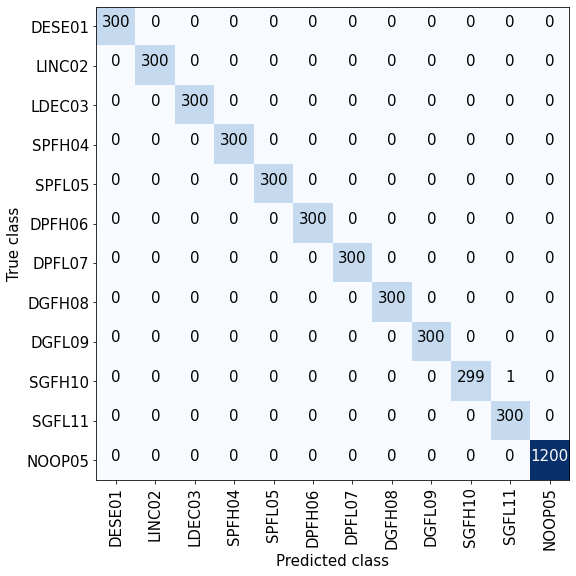

In [ ]:
fig = plt.figure(figsize=(8,9))
plt.rc('font', size=15) #controls default text size
plot_confusion_matrix(cm, classes)
fig.savefig(fname = 'confusion_matrix.eps' ,  bbox_inches='tight')
files.download('./confusion_matrix.eps')